In [26]:
#Code that I wrote when I tried working with zipcodes instead of coordinates from solectria xmls

from uszipcode import SearchEngine
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET

def zipcode_to_coord(zipcodes):
    coord = {"latitude": [], "longitude": []}
    for zipcode in zipcodes:
        search = SearchEngine(simple_zipcode=True)
        zipcode = search.by_zipcode(zipcode)
        coord["latitude"].append(zipcode.lat)
        coord["longitude"].append(zipcode.lng)
    return coord


def files_to_zipcodes(path):
    zipcodes = []
    os.chdir(path)
    for site in os.listdir(path):
        if site[-3:] == 'xml':
            try:
                tree = ET.parse(site)
                root = tree.getroot()
                zipcode = root[0].find("location").find("postal").text
                if zipcode:
                    zipcodes.append(zipcode)
            except:
                pass
    return zipcodes


def files_to_coord(path):
    coord = {"latitude": [], "longitude": []}
    for site in os.listdir(path):
        if site[-3:] == 'xml':
            try:
                tree = ET.parse(site)
                root = tree.getroot()
                lat = root[0].find("location").find("latitude").text
                lng = root[0].find("location").find("longitude").text
                if lat and lng:
                    coord["latitude"].append(lat)
                    coord["longitude"].append(lng)
            except:
                pass
    return coord

In [1]:
#Install postgres library
!pip install psycopg2

In [95]:
#Connect to database and query to get site ids and coordinates of SolarEdge sites
import psycopg2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
from matplotlib.pyplot import figure
try:
    connection = psycopg2.connect(user = "postgres",
                                  password = "INSERT PASSWORD",
                                  host = "INSERT HOST",
                                  port = "5432",
                                  database = "pss")

    cursor = connection.cursor()
    # Print PostgreSQL Connection properties
    print ( connection.get_dsn_parameters(),"\n")

    # Get the sites from the server
    command = "SELECT site_id, longitude, latitude from site;"
    cursor.execute(command)
    result = cursor.fetchall()
except (Exception, psycopg2.Error) as error :
    print ("Error while connecting to PostgreSQL", error)
finally:
    #closing database connection.
        if(connection):
            cursor.close()
            connection.close()
            print("PostgreSQL connection is closed")
            
#Convert to dataframe
solaredge_df = pd.DataFrame(result, columns = ['site_id', 'longitude', 'latitude'])
solaredge_df = solaredge_df.dropna()

{'user': 'postgres', 'dbname': 'pss', 'host': 'pssprod.cyirxynan73z.us-west-1.rds.amazonaws.com', 'port': '5432', 'tty': '', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 

PostgreSQL connection is closed
(38, 3)


In [70]:
#bounds of plot
min_long = -123.400
max_long = -69.500
min_lat = 29.5
max_lat = 49.5

In [96]:
#Get and clean Solectria sites
solectria_df = pd.read_csv('../csv/solectria_sites.csv')
solectria_df = solectria_df.dropna()
solectria_df = solectria_df[solectria_df['longitude'] >= min_long]
solectria_df = solectria_df[solectria_df['longitude'] <= max_long]
solectria_df = solectria_df[solectria_df['latitude'] >= min_lat]
solectria_df = solectria_df[solectria_df['latitude'] <= max_lat]
print(solectria_df.shape)

(568, 13)


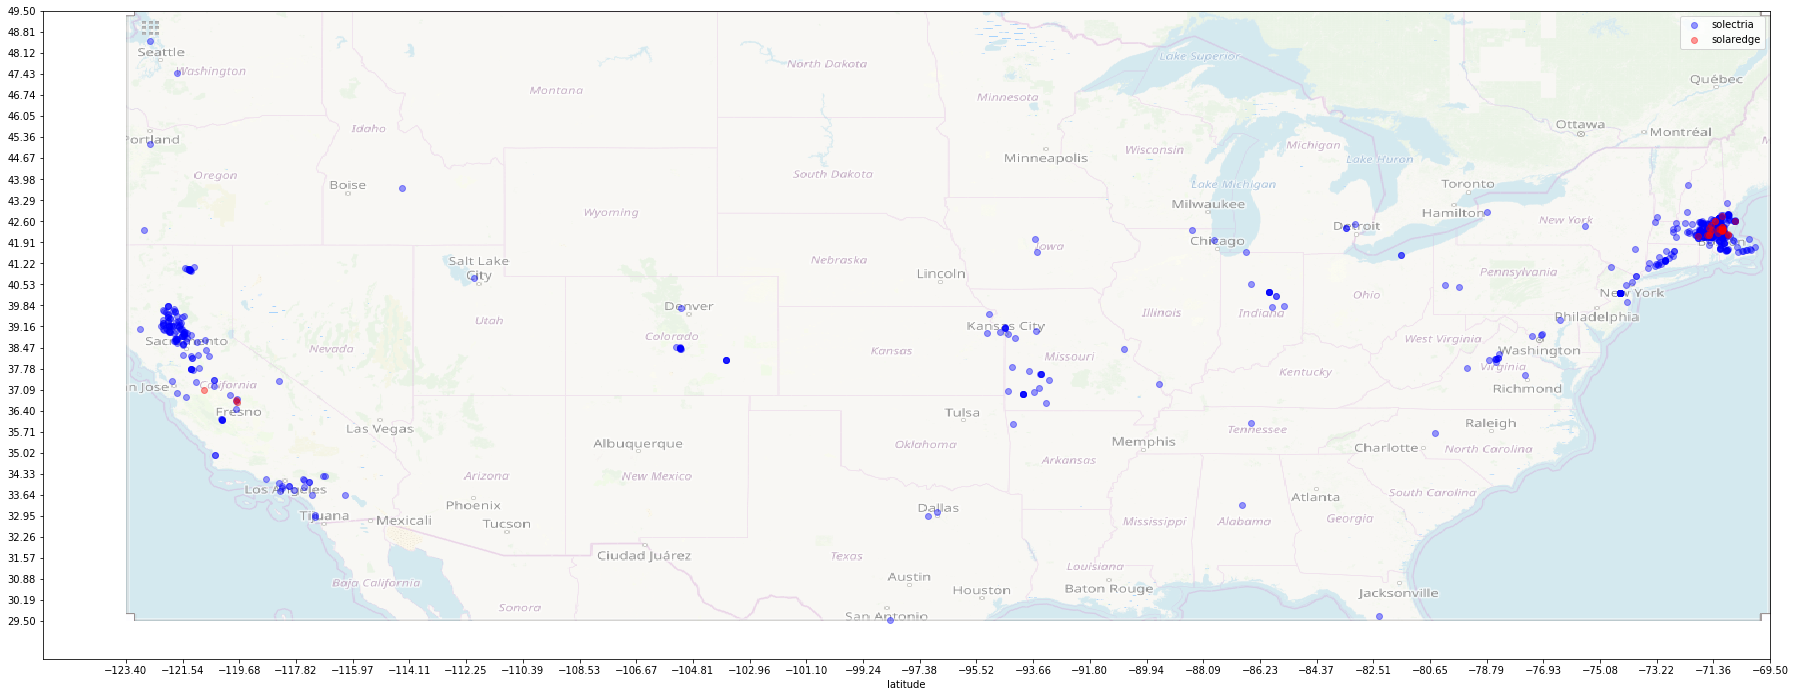

In [97]:
# Plot Both SolarEdge and Solectria sites
map_img=mpimg.imread('US.PNG') #overlays a picture. This is snapped from OSM
plt.imshow(map_img, extent=(min_long, max_long, min_lat, max_lat), alpha=0.5)
plt.scatter(solectria_df['longitude'], solectria_df['latitude'], alpha=0.4, c='blue')
plt.scatter(solaredge_df['longitude'], solaredge_df['latitude'], alpha=0.4, c='red')
plt.xticks(np.linspace(min_long, max_long, num=30))
plt.yticks(np.linspace(min_lat, max_lat, num=30))
plt.legend(['solectria', 'solaredge'])
plt.xlabel("longitude")
plt.xlabel("latitude")
fig = plt.gcf()
fig.set_size_inches(61.9127 / 2, 15) #Give the graph a higher resolution
fig.savefig('test2png.png', dpi=200)
#figure(num=None, figsize=(200, 120), dpi=160, facecolor='w', edgecolor='k')
#plt.figsize(50,50)
plt.show()

In [ ]:
#solaredge_sites = solaredge_df.tolist()
import math

#converts coordinates of two points to distance between them  
def distance_from_coord(long1, long2, lat1, lat2):
    R = 6371
    φ1 = lat1 / 180
    φ2 = lat2 / 180
    Δφ = (lat2-lat1)/ 180
    Δλ = (long2-long1)/180
    a = math.sin(Δφ/2) * math.sin(Δφ/2) + \
        math.cos(φ1) * math.cos(φ2) * \
        math.sin(Δλ/2) * math.sin(Δλ/2);
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a));
    d = R * c;
    return d

In [152]:
sites = []
mean_distances = []
sites_to_match = 3 #How many Solectria sites to select for each SolarEdge site
mean_distance = 0
sites_to_compare = 0
solectria_sites_chosen = []
solaredge_sites_chosen = []
distance_threshold = 10 #How far can matches be before being cut out

# Finds the closest sites for each SolarEdge site. Finding an optimal solution is computationally hard and probably unnessecary,
# so this just goes over the solaredge sites by order and chooses the closest solectria sites, 
# without sampling the same sites more than once
for solaredge_site in solaredge_df.itertuples():
    solectria_id = -1
    solaredge_id = -1
    sites_matched = [-1 for i in range(sites_to_match)]
    most_distant = 0 
    distances = [99999999 for i in range(sites_to_match)]
    for solectria_site in solectria_df.itertuples():
        distance = distance_from_coord(float(getattr(solaredge_site, 'longitude')), 
                                       float(getattr(solectria_site, 'longitude')),
                                       float(getattr(solaredge_site, 'latitude')),
                                       float(getattr(solectria_site, 'latitude')))
        if distance < distances[most_distant] and getattr(solectria_site, 'site_id') not in solectria_sites_chosen:
            solectria_id = getattr(solectria_site, 'site_id')
            solaredge_id = getattr(solaredge_site, 'site_id')
            sites_matched[most_distant] = solectria_id
            distances[most_distant] = distance
            max_distance = distances[0]
            most_distant = 0
            for i in range(len(distances)):
                if distances[i] > max_distance:
                    max_distance = distances[i]
                    most_distant = i
    if distances[most_distant] < distance_threshold:
        for i in range(sites_to_match):
            mean_distance += distances[i]
        solectria_sites_chosen.extend(sites_matched)
        solaredge_sites_chosen.append(solaredge_id)
        sites_to_compare += sites_to_match
mean_distance = mean_distance / sites_to_compare
mean_distances.append(mean_distance)
sites.append(sites_to_compare / sites_to_match)
print("chosen sites:", sites_to_compare / sites_to_match)
print("Mean distance:", mean_distance)
print("Matched solectria sites:", solectria_sites_chosen)
print("Matched solaredge sites:", solaredge_sites_chosen)

    

chosen sites: 36.0
Mean distance: 4.2660242879336625
Matched solectria sites: [2686, 1135, 3452, 3970, 4295, 3930, 3125, 3655, 4632, 4031, 3934, 4267, 4806, 2435, 2690, 918, 5744, 3750, 4065, 3860, 4877, 3590, 4772, 715, 3925, 3347, 3117, 4034, 3693, 3113, 4760, 5629, 4185, 2015, 5178, 5680, 4381, 3577, 4945, 1097, 1759, 3929, 5495, 4898, 4656, 3855, 4721, 4661, 3076, 3778, 2014, 5626, 3793, 2613, 5624, 716, 3491, 4160, 3978, 2026, 5369, 1701, 1700, 3857, 3558, 3095, 2616, 2590, 3009, 3980, 5520, 4334, 4793, 3766, 1703, 1702, 3932, 3931, 3116, 3933, 2263, 4221, 4686, 4635, 183, 5593, 1049, 3859, 3861, 3862, 4099, 1752, 1751, 3805, 3506, 2494, 1603, 2289, 4296, 4112, 948, 3682, 530, 5494, 1238, 4234, 3611, 3718]
Matched solaredge sites: ['570177', '613895', '225542', '605934', '469767', '468575', '704131', '548640', '420924', '516078', '299445', '453519', '452828', '635389', '453884', '452807', '691203', '439323', '345593', '491336', '988889', '829735', '606333', '703541', '571900', '45

Text(0, 0.5, 'Mean distance')

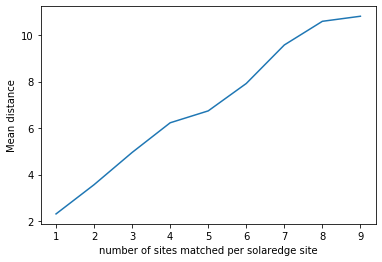

In [146]:
plt.plot(list(range(1, 10)), mean_distances)
plt.xlabel("number of sites matched per solaredge site")
plt.ylabel("Mean distance")

Text(0, 0.5, 'Solaredge sample size')

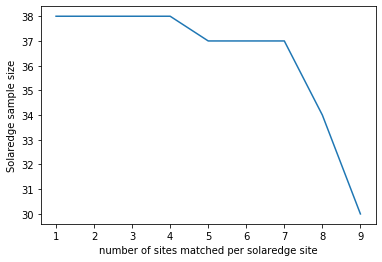

In [147]:
plt.plot(list(range(1, 10)), sites)
plt.xlabel("number of sites matched per solaredge site")
plt.ylabel("Solaredge sample size")